# LCPB 21-22 exercise 4: XGBoost

Alessandro Zanoli, Emerson Rodrigues Vero filho, Luca Giorgetti, Raffaele Gaudio

#### TASK 1

Consider the dataset generated for exercise 03 on convolutional neural networks (CNN), namely the samples of the stochastic time series with labels 0,1,2 depending on the eventual addition of another transient signal.

a) Compare the accuracy of a CNN with that of an XGBoost model trained with the features extracted by tsfresh from same data, in the limit of small datasets. For instance, try values of N=20, 50, 100, 150, 200, 250, 300, 400, 500. In all cases show also the standard deviation of the accuracy, obtained from several independent training and test procedures on different datasets.

b) For task a) we have seen during the lesson that XGBoost finds some features more relevant than others. Find the description of those features in the documentation and try to provide an explanation of why they are relevant for that problem.

c) OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

#### TASK 2

For the labeling of simple two dimensional data (as the one generated during the lesson), try different parameters (gamma, lambda, n_estimators, ...), aiming to find the simplest yet effective XGBoost model that keeps a good accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.random as tf_r
from scipy.signal import detrend # for CNN

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import clone_model

from xgboost import XGBRegressor
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
from keras import regularizers, initializers
from sklearn.metrics import accuracy_score

plt.style.use('seaborn')
plt.rcParams['font.size'] = 14

np.random.seed(12345)
tf_r.set_seed(12345) 
%run plot.py

## Generate Data (1d time series)

In [2]:
# function for the random step, using lambda construction
# int() for cleaner look and for mimiking a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))

def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

[0, -5, 23, 3, -19, 84, 158, 167, 186, 229, 296, 351, 292, 310, 326, 398, 447, 352, 339, 427, 411, 390, 418, 585, 539, 516, 527, 547, 578, 583, 655, 625, 589, 476, 388, 350, 383, 325, 335, 287, 308, 196, 192, 120, 77, 17, 36, 59, 27, 48, 120, 128, 145, 149, 204, 275, 235, 163, 169, 211] 0
[183, 231, 235, 242, 280, 327, 285, 288, 307, 400, 449, 468, 575, 634, 655, 661, 561, 431, 270, 110, 126, 133, 81, 126, 152, 207, 303, 259, 306, 305, 355, 369, 482, 482, 587, 593, 637, 647, 615, 649, 661, 588, 565, 568, 527, 508, 511, 570, 624, 600, 684, 663, 690, 741, 668, 622, 607, 623, 619, 657] 1
[580, 623, 678, 663, 597, 579, 558, 521, 610, 643, 496, 417, 360, 369, 247, 190, 258, 256, 359, 489, 648, 783, 751, 706, 825, 746, 794, 774, 749, 796, 798, 793, 831, 835, 777, 810, 841, 801, 790, 777, 894, 865, 828, 836, 837, 826, 839, 855, 854, 851, 785, 799, 883, 811, 830, 807, 807, 804, 789, 732] 2


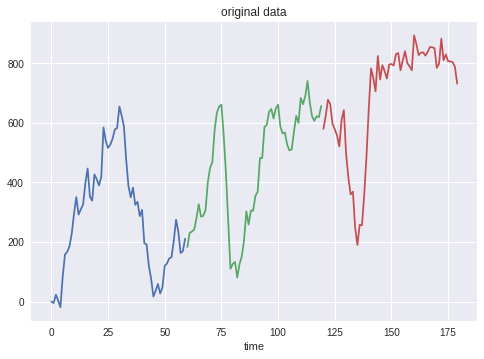

In [3]:
# pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500

# number of data samples
N=10000
# size of each sample of the timeseries
L=60
# step parameters: introduce small positive bias 
DX = 50
bias = 5

y = [0] * N # list of N zeros
x = [[0] * L for i in range(N)] # NxL matrix
                                #
for i in range(N):
    if i>0:
        x[i][0] = x[i-1][-1] + jump(bias,DX) #
    
    for j in range(1,L):
        x[i][j] = x[i][j-1] + jump(bias,DX)
        
    y[i] = i%3 
    ##y[i] = random.randint(0,2)
    if y[i]>0:
        j0 = np.random.randint(0,L-1-Z)
        ###print(i,j0,j1)
        sign = 3-2*y[i]
        for j in range(Z):
            x[i][j0+j] += sign*pattern(j,Z,A)
            
for i in range(min(3,N)):
    print(x[i],y[i])
    

Show_data(x,L,"original data")

In [4]:
#!mkdir DATA
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
print(str0)

fname='DATA/x_'+str0
np.savetxt(fname,x,fmt="%d")
fname='DATA/y_'+str0
np.savetxt(fname,y,fmt="%d")

ts_L60_Z12_A500_DX50_bias5_N10000.dat


## Loading Data

In [5]:
#use the dataset generated in the last exercise (we have to use the same data as in exercise 3 because we will compare the performances of CNN and Xgboost)

str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

data:  10000


## TSFRESH: extract features

In [6]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t) 
    #build time columns
    time_col = np.tile(np.arange(t),N) #genera n colonne di tempi 
    #build var column
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [7]:
df=get_df(x)
df

id  time      value
0          0     0        0.0
1          0     1       -5.0
2          0     2       23.0
3          0     3        3.0
4          0     4      -19.0
...      ...   ...        ...
599995  9999    55  2977193.0
599996  9999    56  2977276.0
599997  9999    57  2977286.0
599998  9999    58  2977386.0
599999  9999    59  2977349.0

[600000 rows x 3 columns]

In [8]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction: 100%|██████████| 20/20 [05:27<00:00, 16.39s/it]


In [9]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [10]:
#look at clean x_features
x_features

value__variance_larger_than_standard_deviation  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
9995                                             1.0   
9996                                             1.0   
9997                                             1.0   
9998                                             1.0   
9999                                             1.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
9995                       1.0                       0.0   
9996                       0.0                       0.0   
9997                       0.0                       0.0   
9998                       0.0                       0.0   
9999                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0            16750.0       6.729150e+06   
1                      1.0            27302.0       1.455619e+07   
2                      1.0            41650.0       3.090479e+07   
3                      1.0            37428.0       2.393510e+07   
4                      1.0            58260.0       6.072359e+07   
...                    ...                ...                ...   
9995                   1.0        178577898.0       5.315011e+14   
9996                   1.0        178600157.0       5.316336e+14   
9997                   1.0        178618515.0       5.317429e+14   
9998                   1.0        178611894.0       5.317035e+14   
9999                   1.0        178619969.0       5.317516e+14   

      value__mean_abs_change  value__mean_change  \
0                  43.101695            3.576271   
1                  44.000000            8.033898   
2                  45.491525            2.576271   
3                  44.372881           -2.169492   
4                  54.593220           10.728814   
...                      ...                 ...   
9995               44.898305            3.813559   
9996               40.288136           10.694915   
9997               48.915254           -1.423729   
9998               57.677966           -0.762712   
9999               41.084746            6.711864   

      value__mean_second_derivative_central  value__median  ...  \
0                                  0.405172          289.5  ...   
1                                 -0.086207          509.5  ...   
2                                 -0.862069          784.0  ...   
3                                  1.008621          631.0  ...   
4                                 -0.422414          909.0  ...   
...                                     ...            ...  ...   
9995                              -0.232759      2976394.0  ...   
9996                              -0.758621      2976629.0  ...   
9997                              -0.422414      2976910.5  ...   
9998                               0.577586      2976930.0  ...   
9999                              -0.612069      2976995.5  ...   

      value__fourier_entropy__bins_2  value__fourier_entropy__bins_3  \
0                           0.239217                        0.283936   
1                           0.317937                        0.379535   
2                           0.142506                        0.142506   
3                           0.317937                        0.473981   
4    

### Split train/validation

In [11]:
# label preparation for CNN
y_CNN = np.zeros((len(y),3))
for i,iy in enumerate(y):
    y_CNN[i][iy]=1

#shuffling data
perm=np.random.permutation(x_features.shape[0])

x_features=x_features.iloc[perm]
y = y[perm]
x = x[perm]
y_CNN = y_CNN[perm]

In [12]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)

if True:
    #rescaling x_features for XGB
    x_features -= np.mean(x_features,axis=0)
    x_features /= np.std(x_features,axis=0)

    # detrending and rescaling x for CNN
    for i in range(len(x)):
        x[i] = detrend(x[i])
    x /= np.var(x)

x = x.reshape((*x.shape,1)) # reshape for CNN

x_XGB_train = x_features[:N_train]
x_CNN_train = x[:N_train]
x_XGB_val = x_features[N_train:]
x_CNN_val = x[N_train:]

    
y_CNN_train = y_CNN[:N_train]
y_CNN_val = y_CNN[N_train:]
y_XGB_train = y[:N_train]
y_XGB_val = y[N_train:]

N_val = N-N_train
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)    

N_train= 8000   N_val= 2000   n_class= 3


# Build models

## XGBoost


In [13]:
#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model_XGB = XGBClassifier(**params)

## CNN Model

In [14]:
reg = regularizers.l2(0.1) 
ini = initializers.RandomNormal(mean=1.0,stddev=0.05,seed=12345)
M = 15 # lenght of kernel: its shape will be M
       # larger than Z=12 which is the size of the pattern

In [15]:
# define the model with no input shape

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=3,kernel_size=M,kernel_initializer=ini,kernel_regularizer=reg,input_shape=(L,1),use_bias=False))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=2,kernel_size=int(M/2)))
model_CNN.add(Flatten())
model_CNN.add(Dense(12,activation='sigmoid')) # just a 12 neurons layer
model_CNN.add(Dense(n_class,activation='softmax'))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=1000,decay_rate=0.9)
opt = tf.keras.optimizers.Adam()

# compile the model
model_CNN.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])


In [16]:
print('----- MODEL SUMMARY ------')
print(model_CNN.summary())

----- MODEL SUMMARY ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 3)             45        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 3)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 2)             44        
                                                                 
 flatten (Flatten)           (None, 34)                0         
                                                                 
 dense (Dense)               (None, 12)                420       
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                             

## XGBoos VS CNN on small datasets

In [17]:
# ENTER THE MEGACELLA OF DEATH

Ns_sub = [20,50,100,150,200,250,300,400,500]
bag_size = 16 # = 8000/500
verbose = True

# dictionary to store accuracy for xgb and cnn model, both for training set and validation set
accuracies = {"xgb" : {"train": np.zeros((len(Ns_sub),16)),
                        "val": np.zeros((len(Ns_sub),16))},
            "cnn" : {"train" : np.zeros((len(Ns_sub),16)),
                    "val" : np.zeros((len(Ns_sub),16))
            }
}

for i_n,N_sub in enumerate(Ns_sub):
    
    if verbose: print("Training {} subsets of size {}\n---------------------\n".format(bag_size,N_sub))

    for i in range(bag_size):
        
        if False: 
            print("Training subset number {} ...".format(i))
            print("Training XGBoost...")

        # XGBoost
        model_XGB.fit(x_XGB_train.iloc[N_sub*i:N_sub*(i+1)].values,y_XGB_train[N_sub*i:N_sub*(i+1)])
        
        y_xgb_pred_train = model_XGB.predict(x_XGB_train.iloc[N_sub*i:N_sub*(i+1)].values)
        y_xgb_pred_val = model_XGB.predict(x_XGB_val.values)

        accuracies["xgb"]["train"][i_n][i] = accuracy_score(y_XGB_train[N_sub*i:N_sub*(i+1)],y_xgb_pred_train)
        accuracies["xgb"]["val"][i_n][i] = accuracy_score(y_XGB_val,y_xgb_pred_val)

        if False: print("Training CNN...")
        # CNN

        model_temp_CNN = keras.models.clone_model(model_CNN) # clone anew
        model_temp_CNN.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
        n_epochs_CNN = 10
        model_temp_CNN.fit(x_CNN_train[N_sub*i:N_sub*(i+1)],y_CNN_train[N_sub*i:N_sub*(i+1)],epochs=n_epochs_CNN)

        y_cnn_pred_train = np.argmax(model_temp_CNN.predict(x_CNN_train[N_sub*i:N_sub*(i+1)]),axis=-1)
        y_cnn_pred_val = np.argmax(model_temp_CNN.predict(x_CNN_val),axis=-1)


        accuracies["cnn"]["train"][i_n][i] = accuracy_score(np.argmax(y_CNN_train[N_sub*i:N_sub*(i+1)],axis=-1),y_cnn_pred_train)
        accuracies["cnn"]["val"][i_n][i] = accuracy_score(np.argmax(y_CNN_val,axis=-1),y_cnn_pred_val)

Training 16 subsets of size 20
---------------------

[18:34:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Epoch 1/10
1/1 [==============================] - 0s 352ms/step - loss: 5.7632 - accuracy: 0.3500
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 5.7492 - accuracy: 0.3500
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 5.7354 - accuracy: 0.3500
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 5.7216 - accuracy: 0.3500
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 5.7078 - accuracy: 0.3500
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 5.6941 - accuracy: 0.3500
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 5.6805 - accuracy: 0.3500
Epoch 8/10
1/1 [===

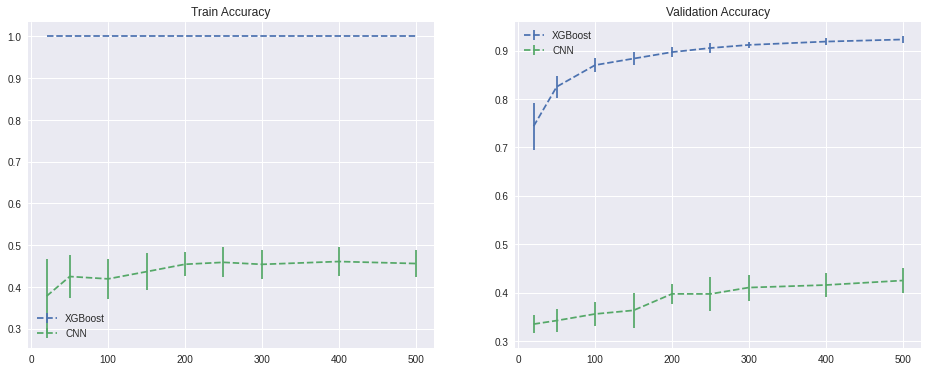

In [18]:
fig,axs = plt.subplots(1,2,figsize=[16,6])
# accuracy of train set
axs[0].set_title("Train Accuracy")
axs[0].errorbar(Ns_sub,np.mean(accuracies['xgb']['train'],axis=1),yerr=np.std(accuracies['xgb']['train'],axis=1),label='XGBoost',linestyle='--')
axs[0].errorbar(Ns_sub,np.mean(accuracies['cnn']['train'],axis=1),yerr=np.std(accuracies['cnn']['train'],axis=1),label='CNN',linestyle='--')
#accuracy of test set
axs[1].set_title("Validation Accuracy")
axs[1].errorbar(Ns_sub,np.mean(accuracies['xgb']['val'],axis=1),yerr=np.std(accuracies['xgb']['val'],axis=1),label='XGBoost',linestyle='--')
axs[1].errorbar(Ns_sub,np.mean(accuracies['cnn']['val'],axis=1),yerr=np.std(accuracies['cnn']['val'],axis=1),label='CNN',linestyle='--')

for ax in axs: ax.legend()


## Feature importance

We will now train XGBoost again on the whole dataset to evaluate feature importance and analyze their behaviour.

In [19]:
model_XGB.fit(x_XGB_train.values,y_XGB_train)

[18:36:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

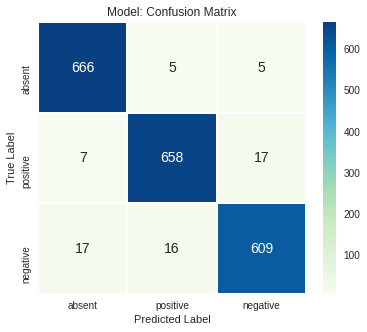

In [20]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_XGB_pred_val = model_XGB.predict(x_XGB_val.values)
show_confusion_matrix(y_XGB_val, y_XGB_pred_val)

As we can see, a lot of features from the tsfresh analysis have zero importance due to the fact that they are constant through the whole dataset and XGBoost recognizes that.

In [21]:
print(model_XGB.feature_importances_[:10])

x_features

[0.         0.00019183 0.00150092 0.         0.00120799 0.
 0.00107343 0.00048434 0.00053506 0.        ]


value__variance_larger_than_standard_deviation  \
8206                                             NaN   
8606                                             NaN   
3992                                             NaN   
4168                                             NaN   
3165                                             NaN   
...                                              ...   
3039                                             NaN   
7677                                             NaN   
6444                                             NaN   
6088                                             NaN   
7219                                             NaN   

      value__has_duplicate_max  value__has_duplicate_min  \
8206                 -0.153773                 -0.153773   
8606                 -0.153773                 -0.153773   
3992                 -0.153773                 -0.153773   
4168                 -0.153773                 -0.153773   
3165                 -0.153773                 -0.153773   
...                        ...                       ...   
3039                 -0.153773                 -0.153773   
7677                 -0.153773                 -0.153773   
6444                 -0.153773                 -0.153773   
6088                 -0.153773                 -0.153773   
7219                 -0.153773                 -0.153773   

      value__has_duplicate  value__sum_values  value__abs_energy  \
8206               0.18123           1.098472           1.117824   
8606               0.18123           1.250723           1.365808   
3992               0.18123          -0.350933          -0.586421   
4168               0.18123          -0.288082          -0.537164   
3165               0.18123          -0.638498          -0.783289   
...                    ...                ...                ...   
3039               0.18123          -0.676692          -0.805918   
7677               0.18123           0.917760           0.840502   
6444               0.18123           0.499499           0.269482   
6088               0.18123           0.374438           0.117962   
7219               0.18123           0.766174           0.622120   

      value__mean_abs_change  value__mean_change  \
8206                0.967978           -3.416400   
8606                2.025201           -1.473585   
3992                1.044627           -1.118192   
4168               -0.002024           -0.649600   
3165               -1.109465           -1.715779   
...                      ...                 ...   
3039               -1.437204           -0.304737   
7677               -0.379981           -1.510441   
6444               -0.834587           -0.889161   
6088                0.518659            2.333068   
7219                0.360075           -0.531136   

      value__mean_second_derivative_central  value__median  ...  \
8206                               0.597896       1.098548  ...   
8606                               0.512744       1.250733  ...   
3992                               0.001834      -0.350893  ...   
4168                               0.186329      -0.288129  ...   
3165                              -0.395541      -0.638431  ...   
...                                     ...            ...  ...   
3039                              -0.111702      -0.676702  ...   
7677                               1.832595       0.917755  ...   
6444                              -0.849684       0.499520  ...   
6088                               2.400274       0.374225  ...   
7219                               0.541128       0.766095  ...   

      value__fourier_entropy__bins_2  value__fourier_entropy__bins_3  \
8206                        2.130041                        1.968170   
8606                        1.273394                        1.353585   
3992                        0.260949                        0.593556   
4168                       -0.982893                       -1.313867   
3165 

Let us now sort these features by importance and plot them:

In [22]:
# these are the extracted features' name sorted by their feature importance
x_features.columns[np.argsort(model_XGB.feature_importances_)[::-1]]
# let us now subset the N most important features
n_features = 6
x_features_important = x_features.iloc[:,np.argsort(model_XGB.feature_importances_)[::-1][:n_features]]

In [23]:
for feature in range(n_features):
    print("Feature: ")
    print(x_features_important.columns[feature])
    print("Importance:")
    print(np.sort(model_XGB.feature_importances_)[::-1][feature])
    print("")

Feature: 
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4
Importance:
0.19755706

Feature: 
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0
Importance:
0.15511869

Feature: 
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0
Importance:
0.10390203

Feature: 
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0
Importance:
0.07580629

Feature: 
value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"
Importance:
0.026843399

Feature: 
value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0
Importance:
0.020216532



<ipython-input-24-5c2bfaae4cad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_features_important['class']=y


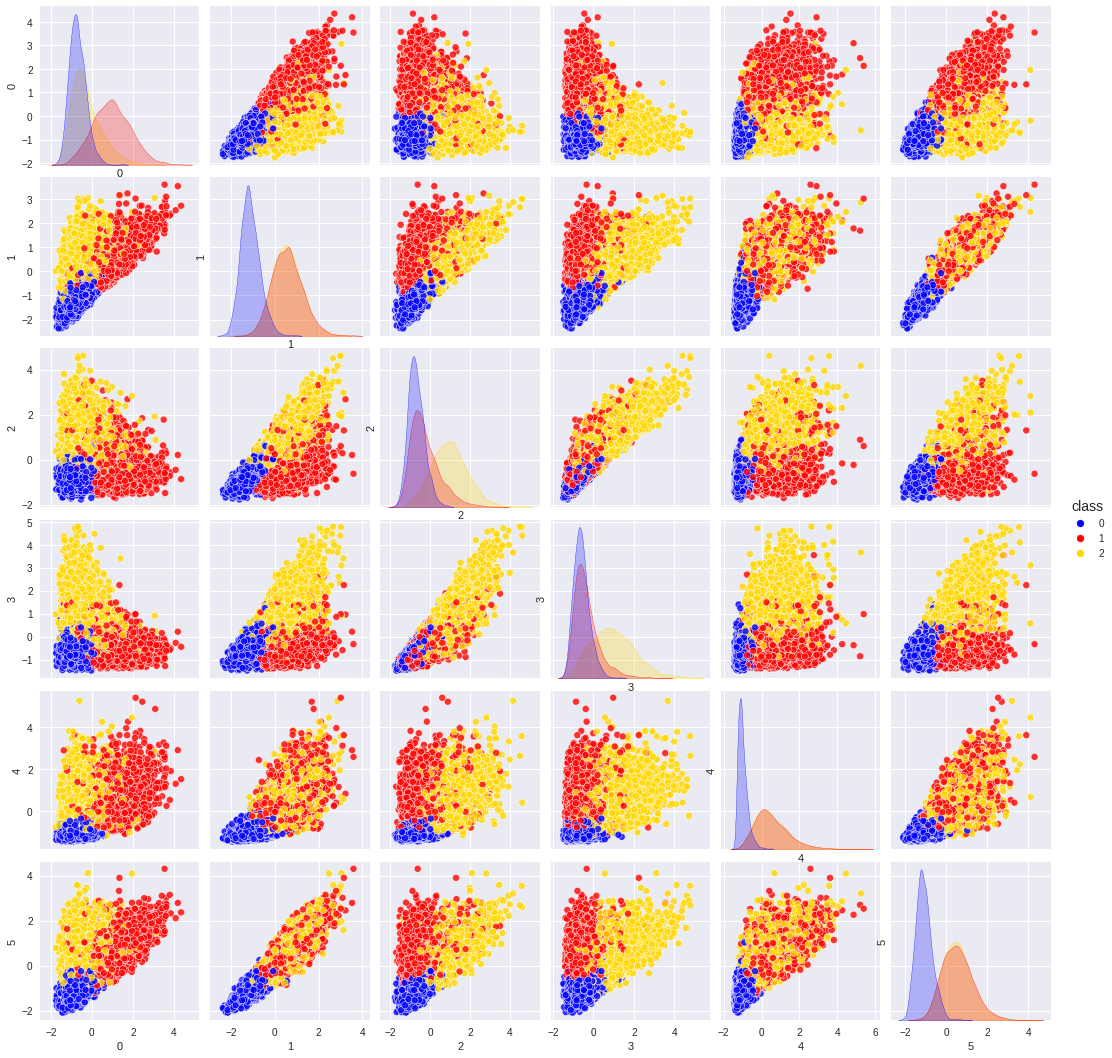

In [24]:
x_features_important['class']=y

#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
pairgrid=sns.pairplot(x_features_important,hue='class',plot_kws=dict(alpha=0.8),palette=pal);
for i in range(6):
    for j in range(6):
        pairgrid.axes[i,j].set_ylabel(str(i))
        pairgrid.axes[i,j].set_xlabel(str(j))
        

Almost all of the 6 most important feature consist in quantile analysis done by `tsfresh` over the time series: in particular, they are the result of a function `change_quantiles(x,ql,qh,isabs,f_agg)` that `tsfresh` performs over the time series.

<blockquote>
    
    tsfresh.feature_extraction.feature_calculators.change_quantiles(x, ql, qh, isabs, f_agg)


    First fixes a corridor given by the quantiles ql and qh of the distribution of x. Then calculates the average, absolute value of consecutive changes of the series x inside this corridor.

    Think about selecting a corridor on the y-Axis and only calculating the mean of the absolute change of the time series inside this corridor.

</blockquote>

So basically restricting the time series to a interval over the y axis and then calculating the average derivative. 
Take for instance the first, by importance, of the features extracted: 

In [25]:
print(x_features_important.columns[0])

value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4


Setting `qh` to `1` and `ql` to `0` means restricting the time series between the highest value of the time series and the lowest, so basically not restricting the time series at all. As we can see from the pair plot (feature 0 vs feature 0, upper left corner), this separates well the samples labeled 0 (that correspond to a bump with amplitude 3 as defined by our data generation routine) from the samples labeled 1 and 2 that, in turn, correspond with bumps of amplitude 1 and -1; these introduce in the time series the same contribution to the average absolute value of the derivative, as they are, in absolute value, the same amplitude.

Meanwhile, if we take a look at the feature 0 vs feature 1 of the pairplot, we are able to further distinguish between the 1 and 2 classes: what is feature 1?

In [26]:
print(x_features_important.columns[1])

value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0


So it's the same procedure operated on the time series, but this time we restrict the y axis window by excluding the upper 40% of the dataset; this way, the algorithm is apparently able to distinguish between the "hill like" bump (label 1, positive amplitude) and the "pit like" bump with negative amplitude. 

So these features extracted from the time series by `tsfresh` routine are extremely relevant for XGBoost, but they are far from being able of telling the whole story: in facts, if we sum up their importance, it only adds up to:

In [27]:
print("{:.2%}".format(np.sum(np.sort(model_XGB.feature_importances_)[::-1][:n_features])))

57.94%


## FFNN over tsfresh
### (optional)

In [28]:
x_features_CNN = x_features.dropna(axis=1)

L_features = x_features_CNN.shape[1]
print(L_features)

model_FFNN = Sequential()
model_FFNN.add(Dense(20,input_shape=(L_features,),activation='relu'))
model_FFNN.add(Dense(6,activation='relu'))
model_FFNN.add(Dropout(0.2))
model_FFNN.add(Dense(3,activation='sigmoid')) # output

print(model_FFNN.summary())

model_FFNN.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

447
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                8960      
                                                                 
 dense_3 (Dense)             (None, 6)                 126       
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 3)                 21        
                                                                 
Total params: 9,107
Trainable params: 9,107
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
x_FFNN_train=x_XGB_train.dropna(axis=1)
x_FFNN_val=x_XGB_val.dropna(axis=1)

In [30]:
# we need labels to be like the CNN
n_epochs = 100
model_FFNN.fit(x_FFNN_train,y_CNN_train,epochs=n_epochs)

Epoch 1/100
250/250 [==============================] - 0s 614us/step - loss: 0.3883 - accuracy: 0.7149
Epoch 2/100
250/250 [==============================] - 0s 609us/step - loss: 0.2224 - accuracy: 0.8760
Epoch 3/100
250/250 [==============================] - 0s 744us/step - loss: 0.1679 - accuracy: 0.9029
Epoch 4/100
250/250 [==============================] - 0s 613us/step - loss: 0.1442 - accuracy: 0.9101
Epoch 5/100
250/250 [==============================] - 0s 612us/step - loss: 0.1232 - accuracy: 0.9229
Epoch 6/100
250/250 [==============================] - 0s 613us/step - loss: 0.1097 - accuracy: 0.9252
Epoch 7/100
250/250 [==============================] - 0s 756us/step - loss: 0.0983 - accuracy: 0.9380
Epoch 8/100
250/250 [==============================] - 0s 612us/step - loss: 0.0953 - accuracy: 0.9386
Epoch 9/100
250/250 [==============================] - 0s 614us/step - loss: 0.0886 - accuracy: 0.9402
Epoch 10/100
250/250 [==============================] - 0s 610us/step - l

FFNN performance:


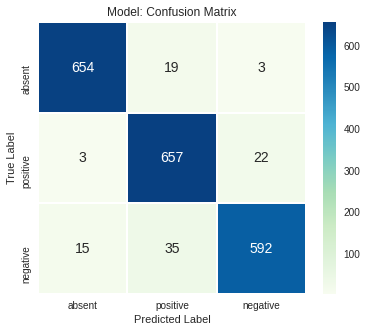

XGBoost performance:


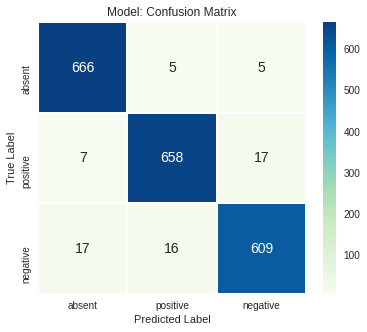

In [31]:
y_FFNN_pred_val = np.argmax(model_FFNN.predict(x_FFNN_val.values),axis=1)
print("FFNN performance:")
show_confusion_matrix(y_XGB_val, y_FFNN_pred_val) # we will use XGB's y formulation because of how labels are defined
                                                  # sklearn metrics does not like labeling like [1,0,0] etc...

print("XGBoost performance:")
show_confusion_matrix(y_XGB_val, y_XGB_pred_val)

As we can see, XGBoost still outperforms our Feed Forward Neural Network model, at way less computational cost. Still, FFNN model could be further improved, either by modifying its architecture or by having it consider only the most important features: we will do that now.

In [32]:
x_FFNN_train_less = x_XGB_train.iloc[:,np.argsort(model_XGB.feature_importances_)[::-1][:n_features]]
x_FFNN_val_less = x_XGB_val.iloc[:,np.argsort(model_XGB.feature_importances_)[::-1][:n_features]]

L_features = x_FFNN_train_less.shape[1]
print(L_features)

model_FFNN_less = Sequential()
model_FFNN_less.add(Dense(20,input_shape=(L_features,),activation='relu'))
model_FFNN_less.add(Dense(6,activation='relu'))
model_FFNN_less.add(Dropout(0.2))
model_FFNN_less.add(Dense(3,activation='sigmoid')) # output

print(model_FFNN_less.summary())

model_FFNN_less.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                140       
                                                                 
 dense_6 (Dense)             (None, 6)                 126       
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_7 (Dense)             (None, 3)                 21        
                                                                 
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# we need labels to be like the CNN
n_epochs = 100
model_FFNN_less.fit(x_FFNN_train_less,y_CNN_train,epochs=n_epochs)

Epoch 1/100
250/250 [==============================] - 0s 521us/step - loss: 0.5478 - accuracy: 0.6154
Epoch 2/100
250/250 [==============================] - 0s 510us/step - loss: 0.3530 - accuracy: 0.7424
Epoch 3/100
250/250 [==============================] - 0s 501us/step - loss: 0.3243 - accuracy: 0.7435
Epoch 4/100
250/250 [==============================] - 0s 510us/step - loss: 0.3144 - accuracy: 0.7492
Epoch 5/100
250/250 [==============================] - 0s 501us/step - loss: 0.3043 - accuracy: 0.7601
Epoch 6/100
250/250 [==============================] - 0s 518us/step - loss: 0.3015 - accuracy: 0.7764
Epoch 7/100
250/250 [==============================] - 0s 512us/step - loss: 0.2996 - accuracy: 0.8001
Epoch 8/100
250/250 [==============================] - 0s 505us/step - loss: 0.2956 - accuracy: 0.8019
Epoch 9/100
250/250 [==============================] - 0s 508us/step - loss: 0.2943 - accuracy: 0.8071
Epoch 10/100
250/250 [==============================] - 0s 512us/step - l

FFNN with less features as input performance:


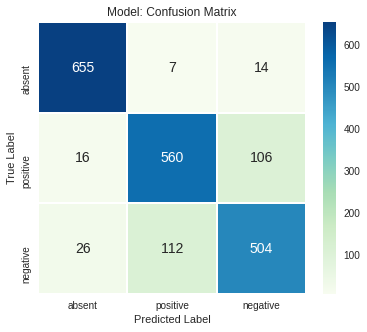

XGBoost performance:


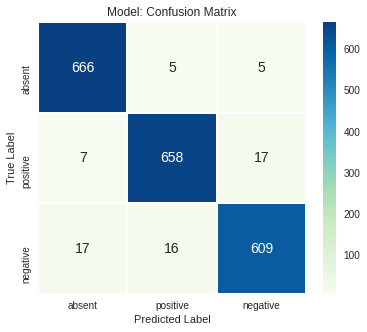

In [34]:
y_FFNN_less_pred_val = np.argmax(model_FFNN_less.predict(x_FFNN_val_less.values),axis=1)
print("FFNN with less features as input performance:")
show_confusion_matrix(y_XGB_val, y_FFNN_less_pred_val) # we will use XGB's y formulation because of how labels are defined
                                                  # sklearn metrics does not like labeling like [1,0,0] etc...

print("XGBoost performance:")
show_confusion_matrix(y_XGB_val, y_XGB_pred_val)

As we can see, the FFNN trained with less features as input actually performs slightly worse than the fully trained model; this is nonetheless promising, since that means that, even with way less trainable parameters, we are able to have sufficiently accurate prediciton, and that means that there is more room to eventually play with the NN architecture, the optimization algorithm and whatnot.

# 2) 2D data labeling

First let's generate data, using the same simple labeling function we used dureing the lesson:

In [35]:
S = 2
N = 2000
N_train = 1000
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)

CASE = 2

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

x_train = x[:N_train]
y_train = y[:N_train]
x_test = x[:N_test]
y_test = y[:N_test]


[-1.85680382  0.56100849] 0
[1.27663531 1.91509224] 0
[-1.91427844  1.48080036] 0
[ 1.43046382 -0.80560664] 1
[ 0.07534034 -0.54890758] 0


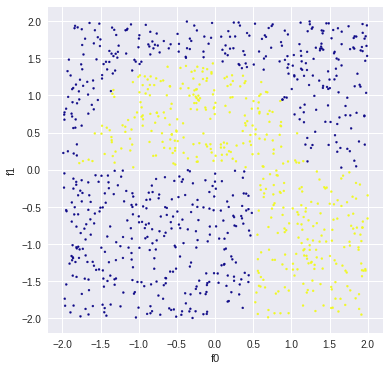

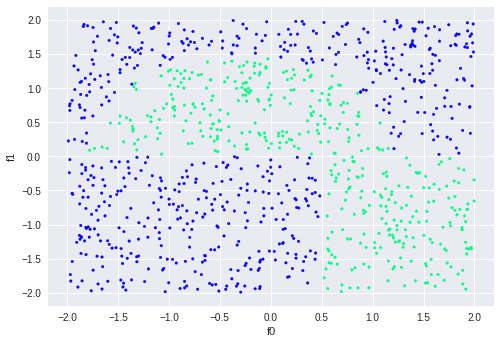

In [36]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
plt.show()
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

In [37]:
def classify(clf=XGBClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

LAMBDA =  1
[18:37:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.10%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


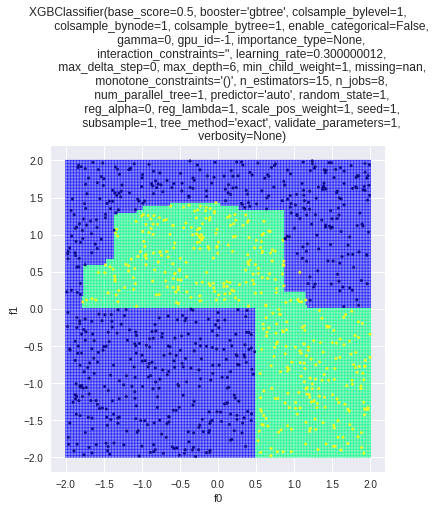

LAMBDA =  0.1
[18:37:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


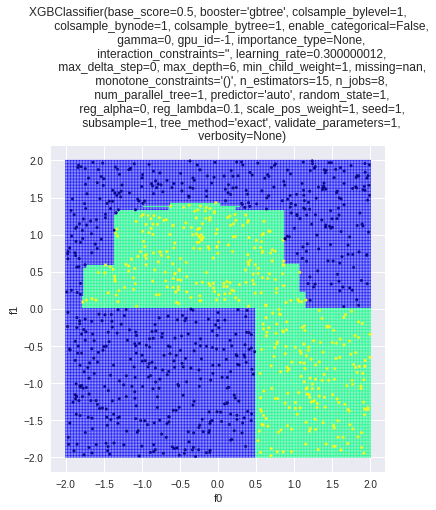

LAMBDA =  0.01
[18:37:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


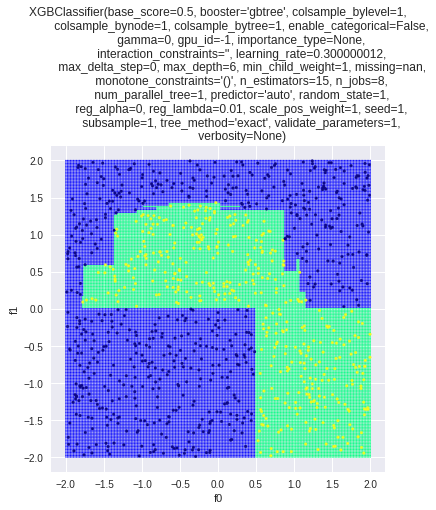

LAMBDA =  0.001
[18:37:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


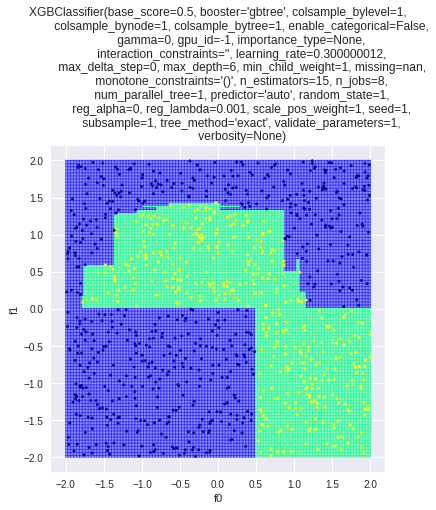

In [38]:
params = {"seed":1,
          "objective":'binary:logistic',
          "reg_lambda":0.001, 
          "n_estimators":15}  # before was 10

# let's try to keep n_estimators high and then simplify other parameters, trying to reduce variance while keeping the bias of a single estimator

for ex in range(4):
    params['reg_lambda'] = 10**(-ex)
    print("LAMBDA = ",params['reg_lambda'])
    classify(XGBClassifier(**params))
    


So, higher lambda produces better results over the test set as it prevents overfitting, but not too much otherwise the bias becomes too large: let's try so to simply the model even further.

Let's act on `gamma`, another regularization parameter that penalizes growing more complex tree.

GAMMA =  0
[18:39:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


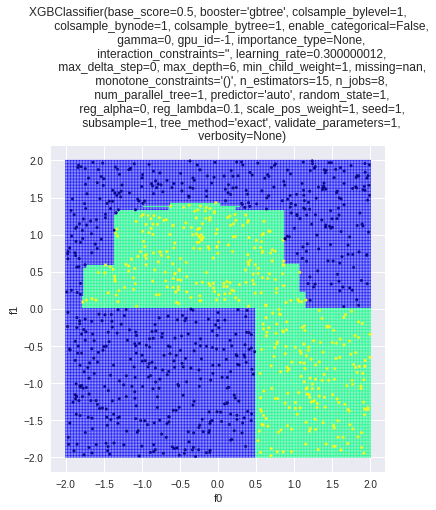

num_trees= 15


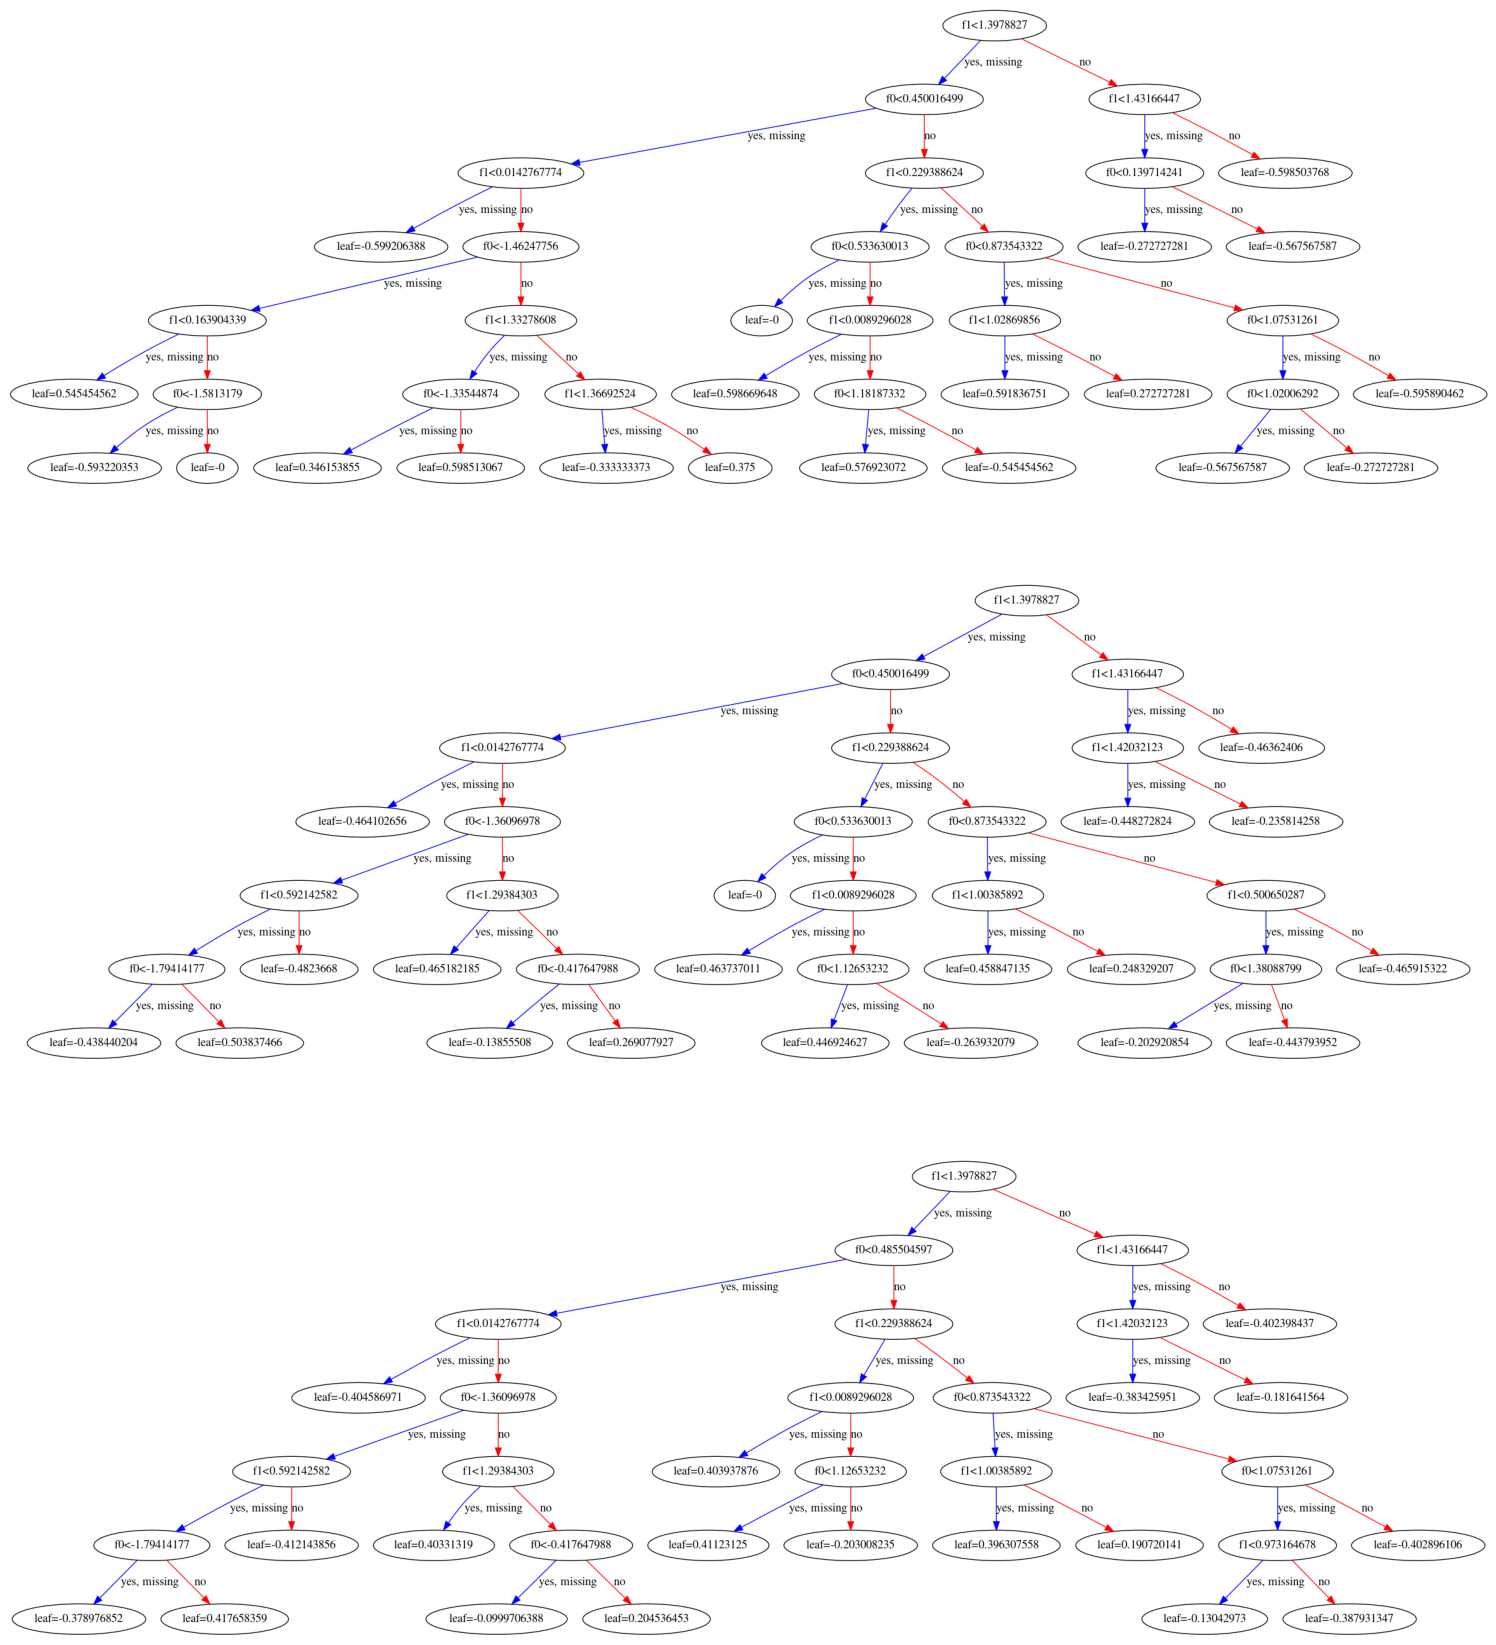

GAMMA =  0.001
[18:39:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


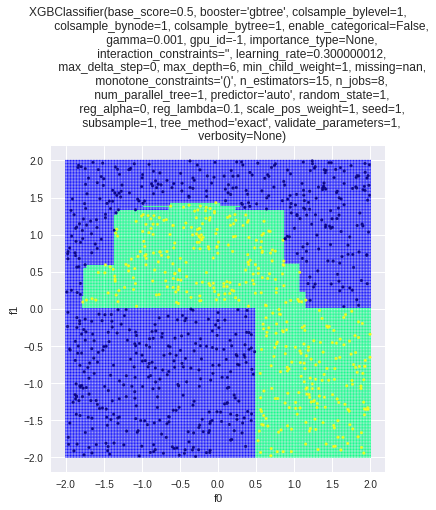

num_trees= 15


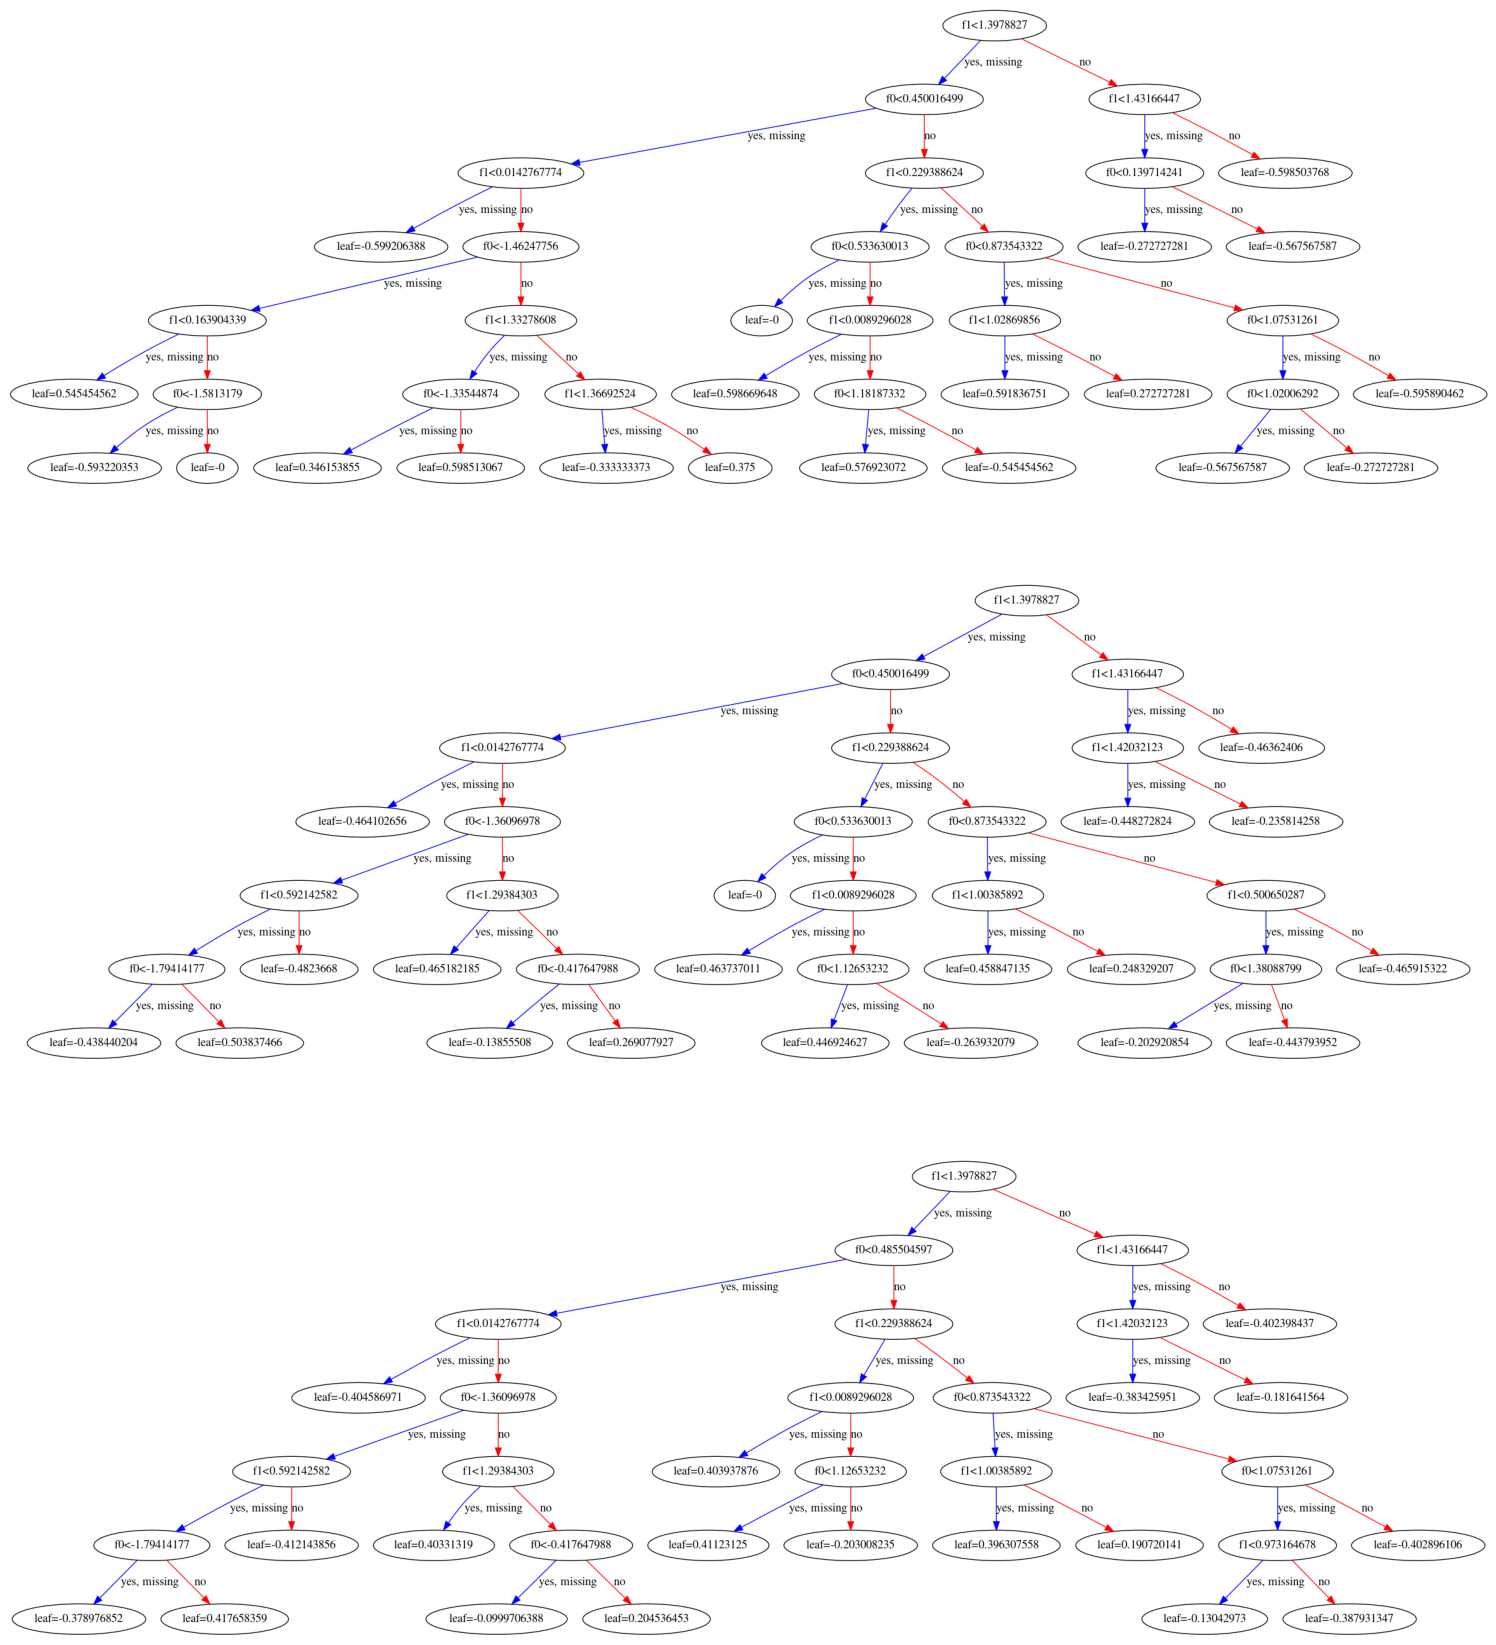

GAMMA =  0.01
[18:39:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


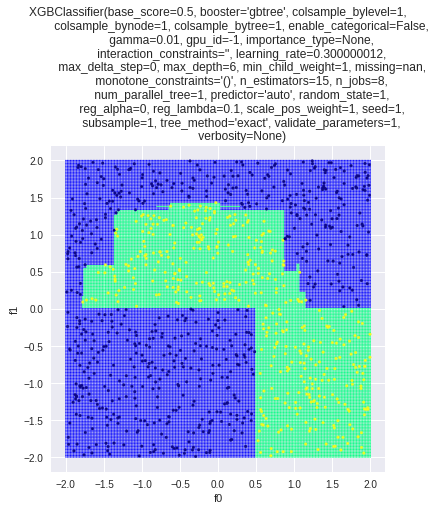

num_trees= 15


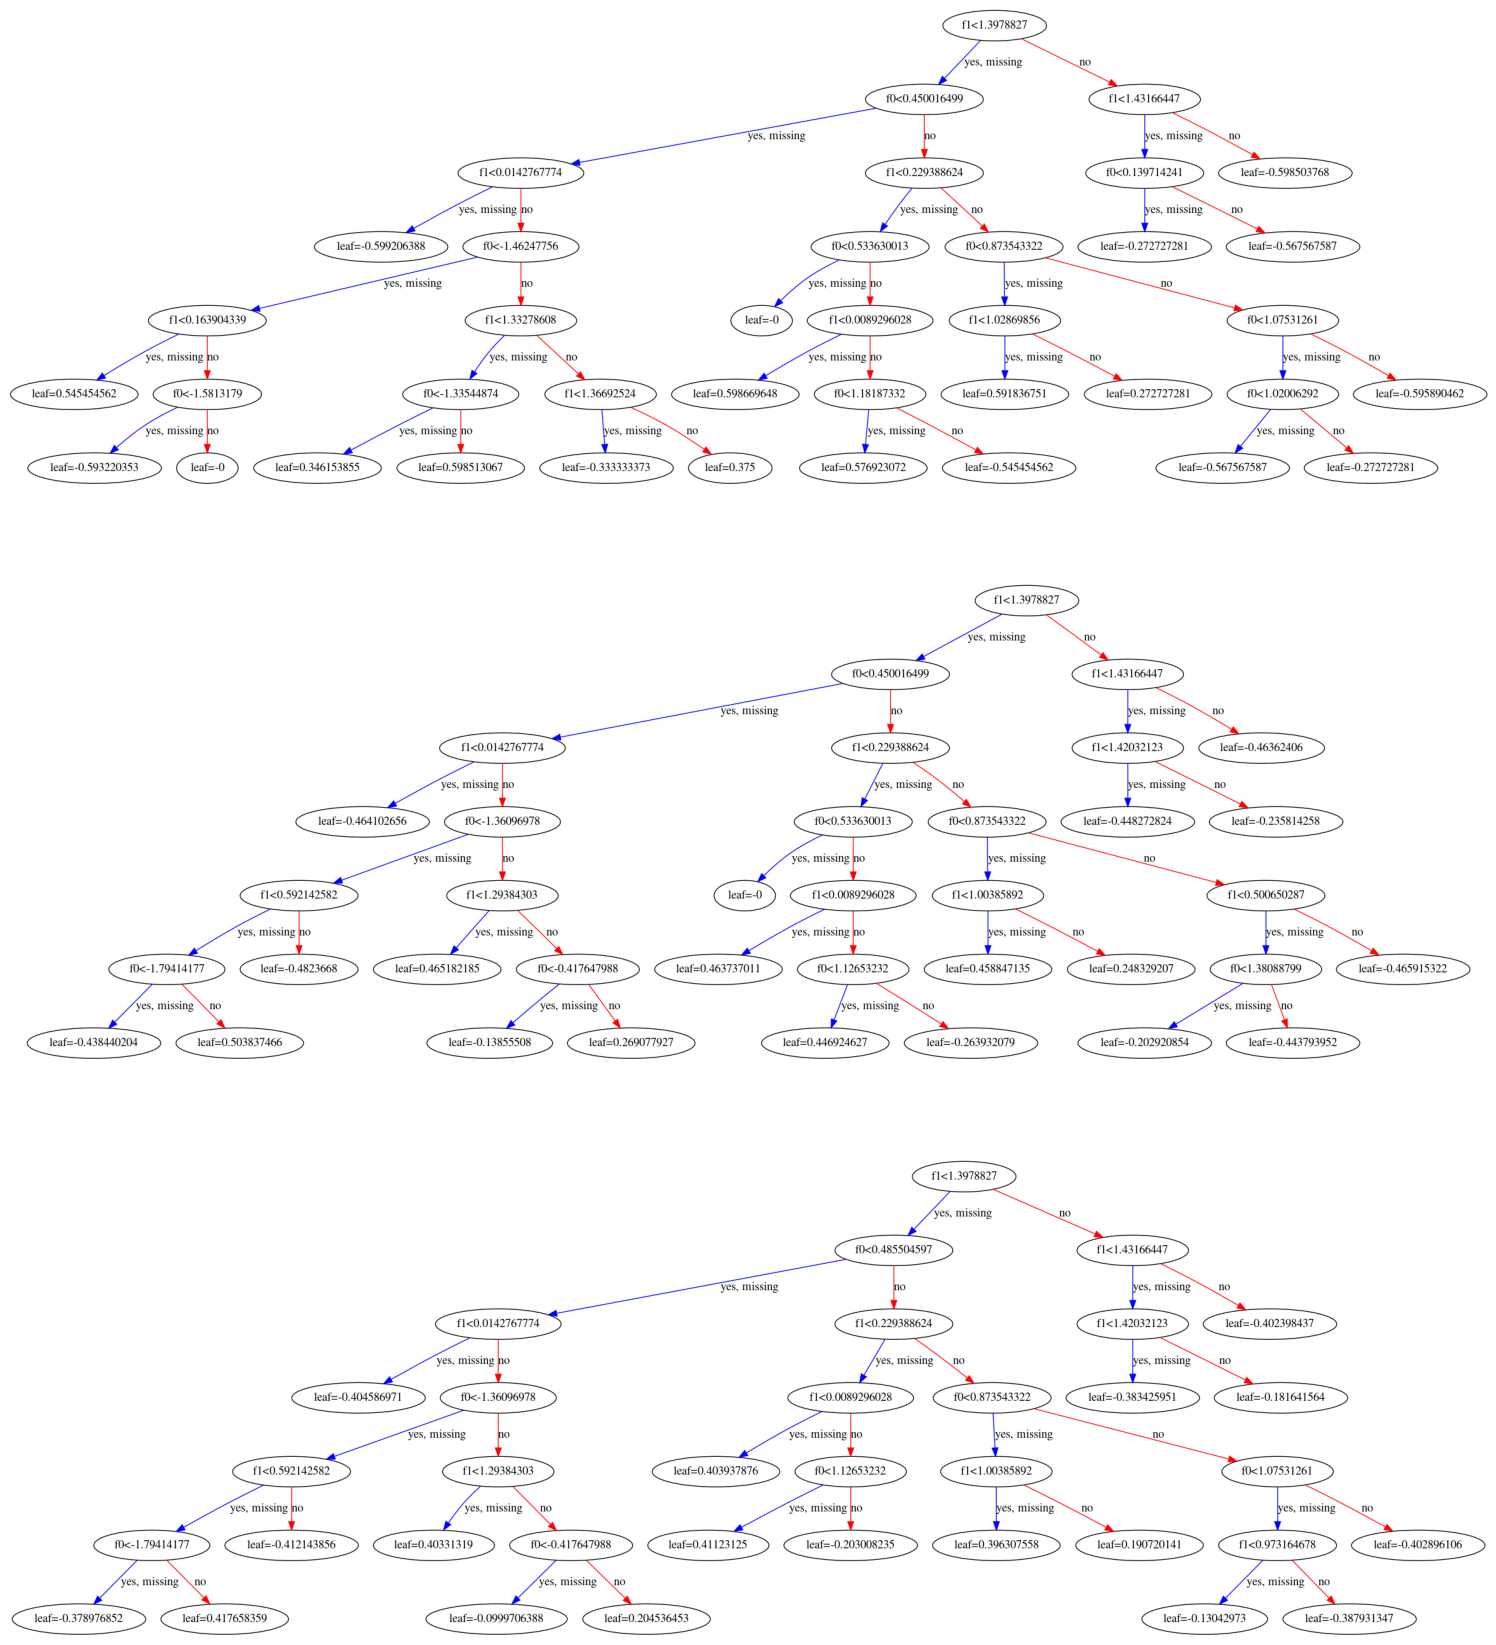

GAMMA =  0.1
[18:39:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.00%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


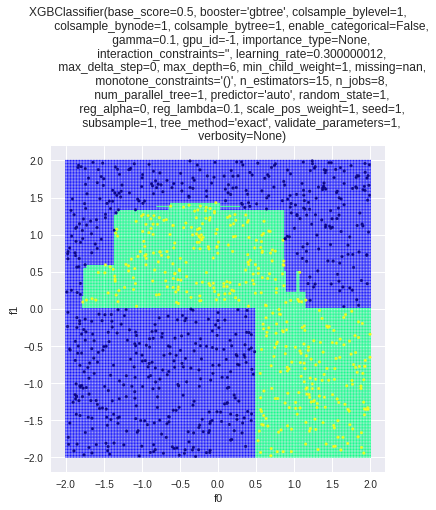

num_trees= 15


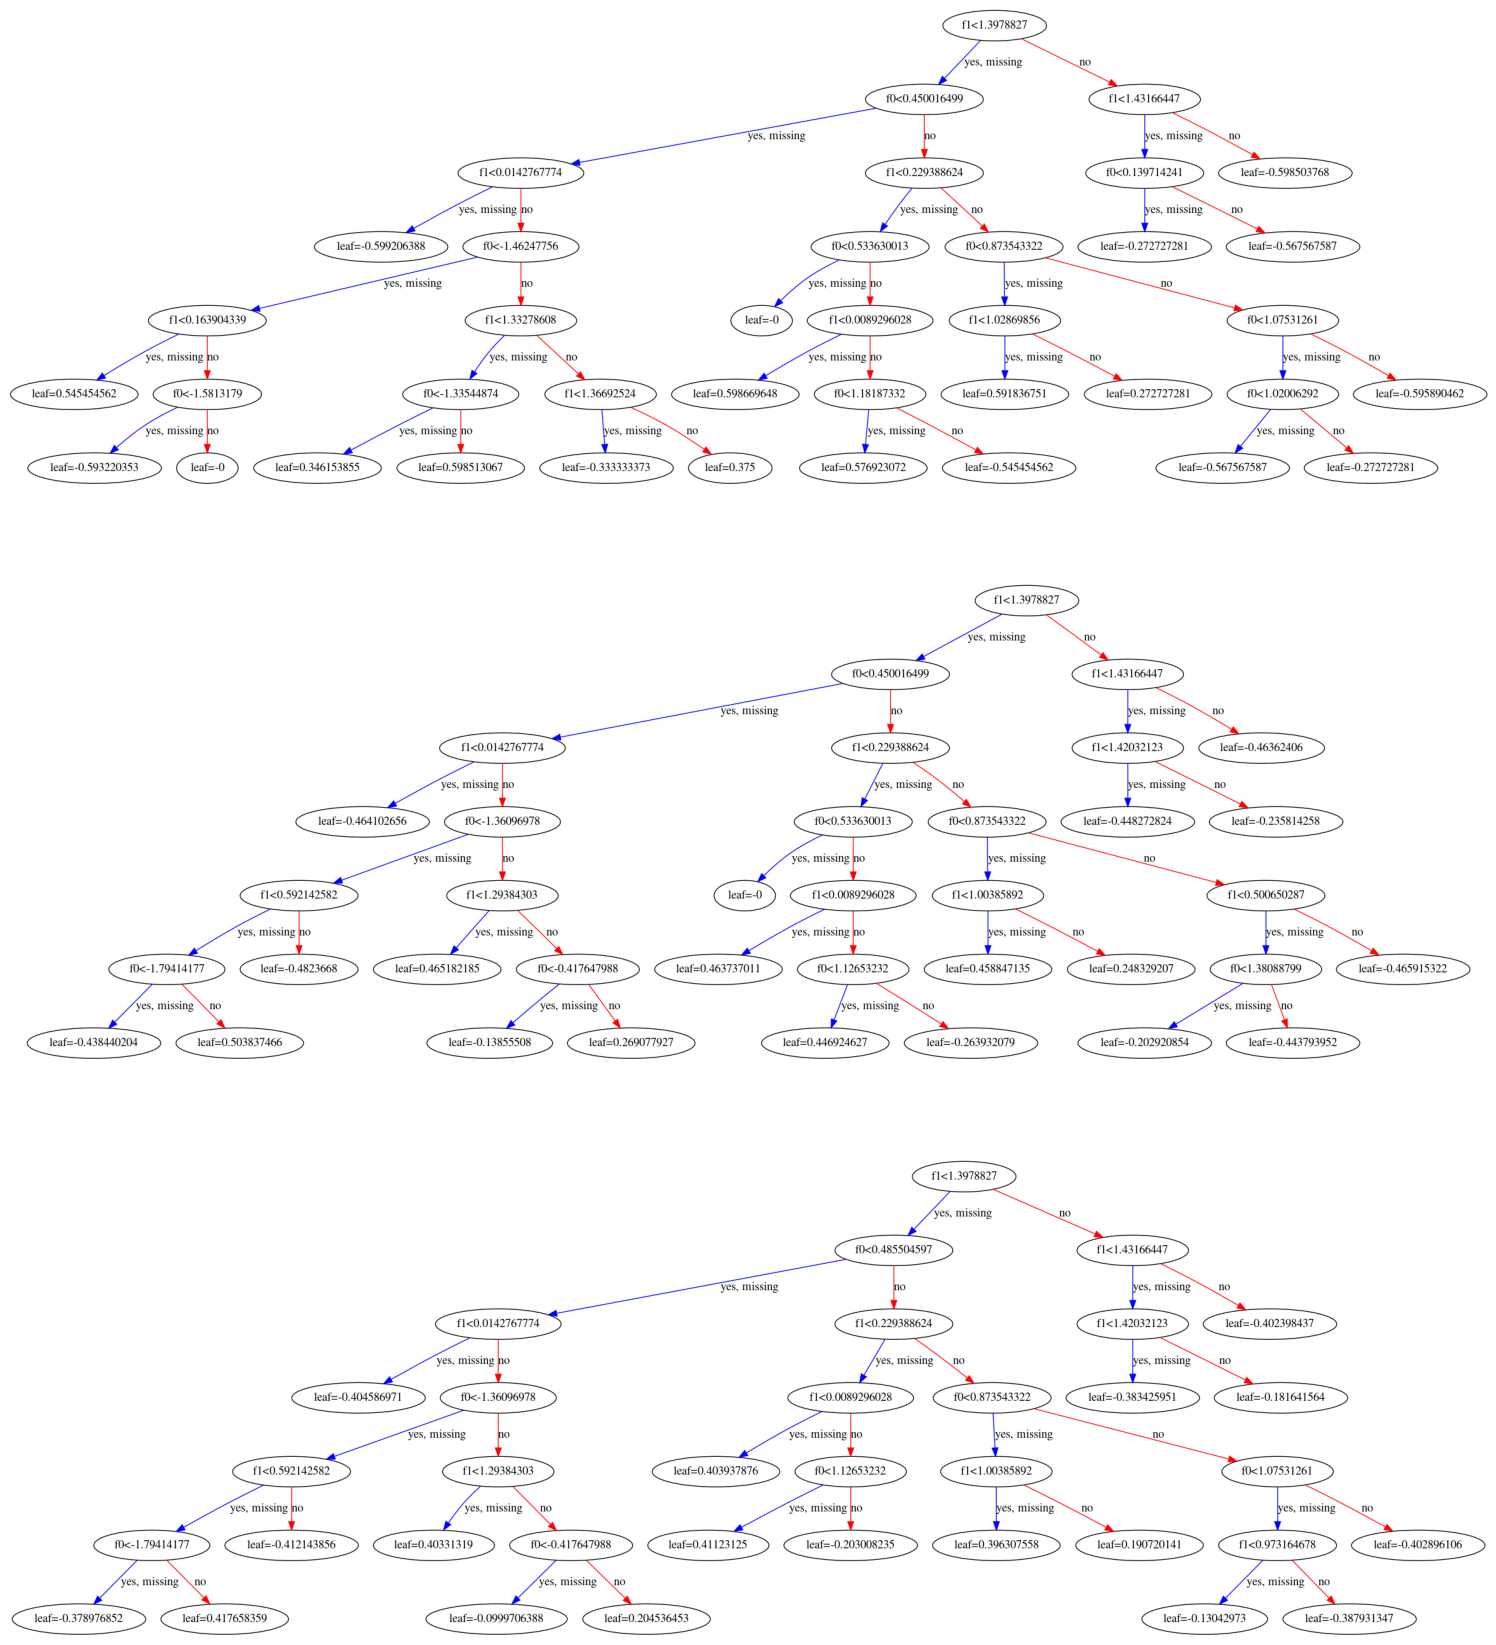

GAMMA =  1
[18:39:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.10%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


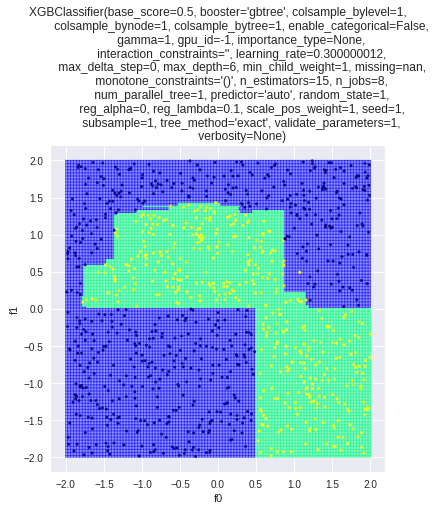

num_trees= 15


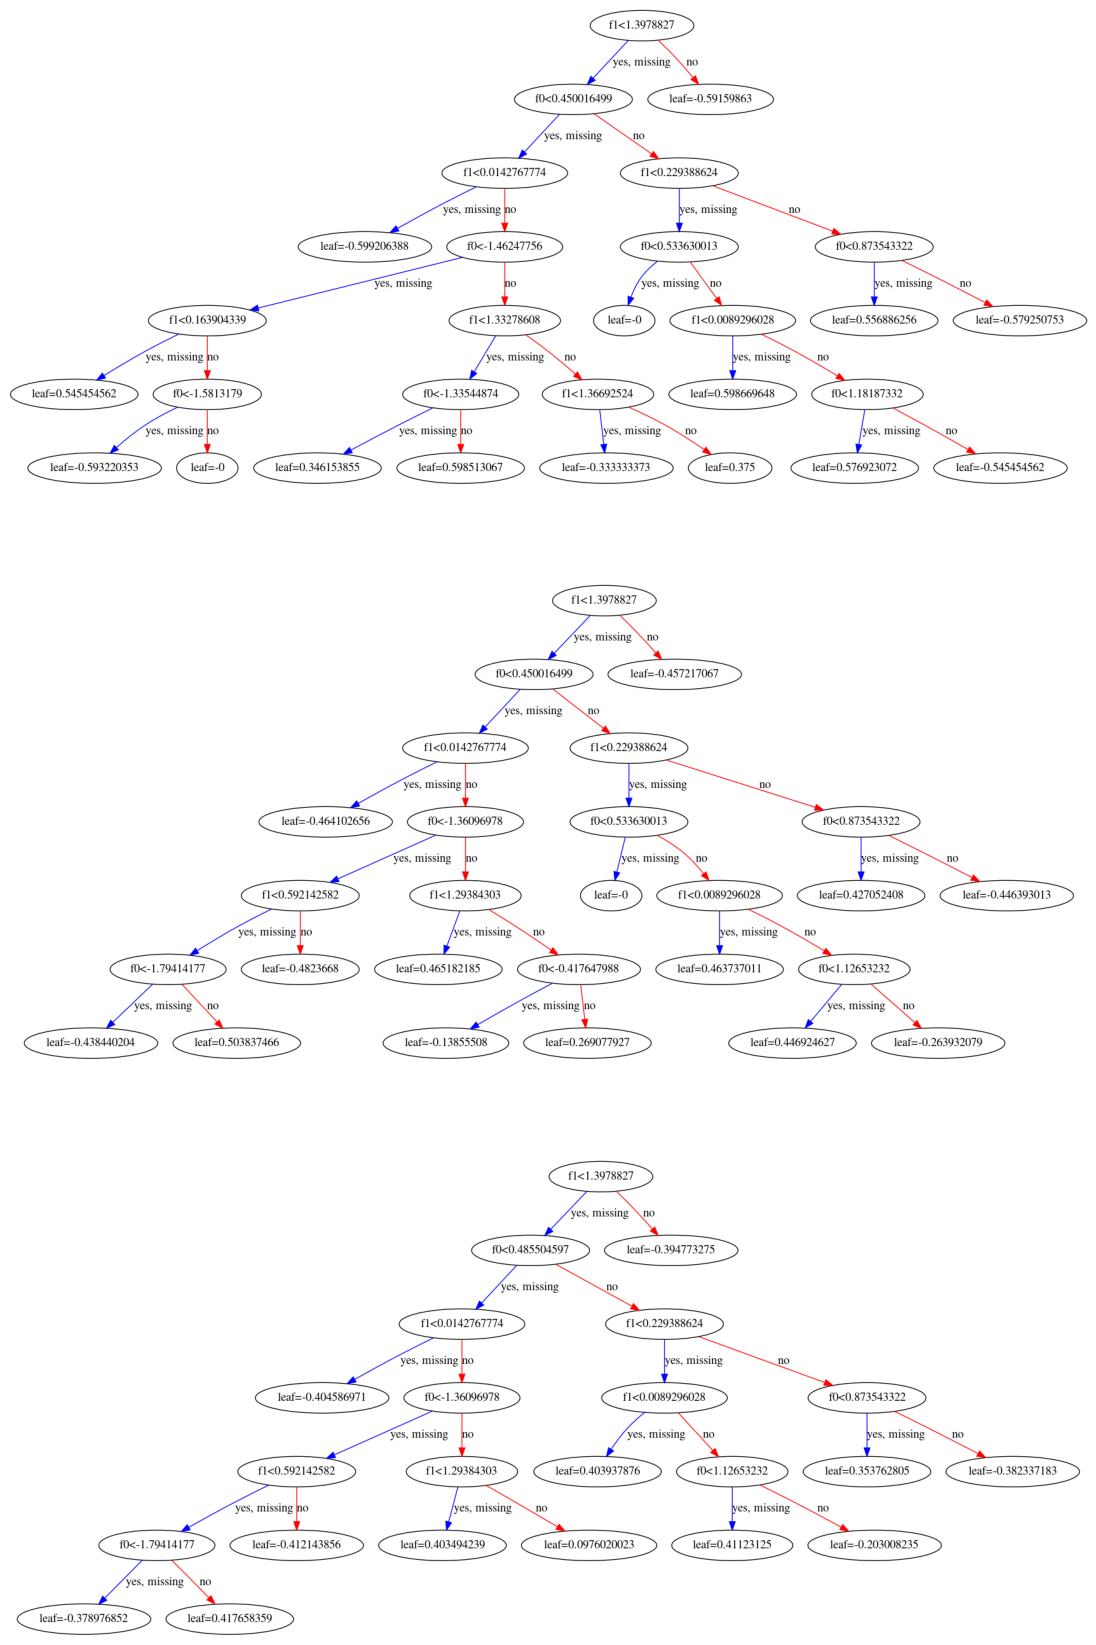

GAMMA =  10
[18:39:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
errors: 0.70%


/home/zano/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


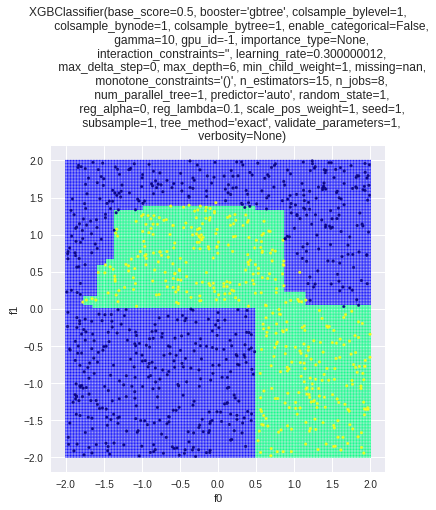

num_trees= 15


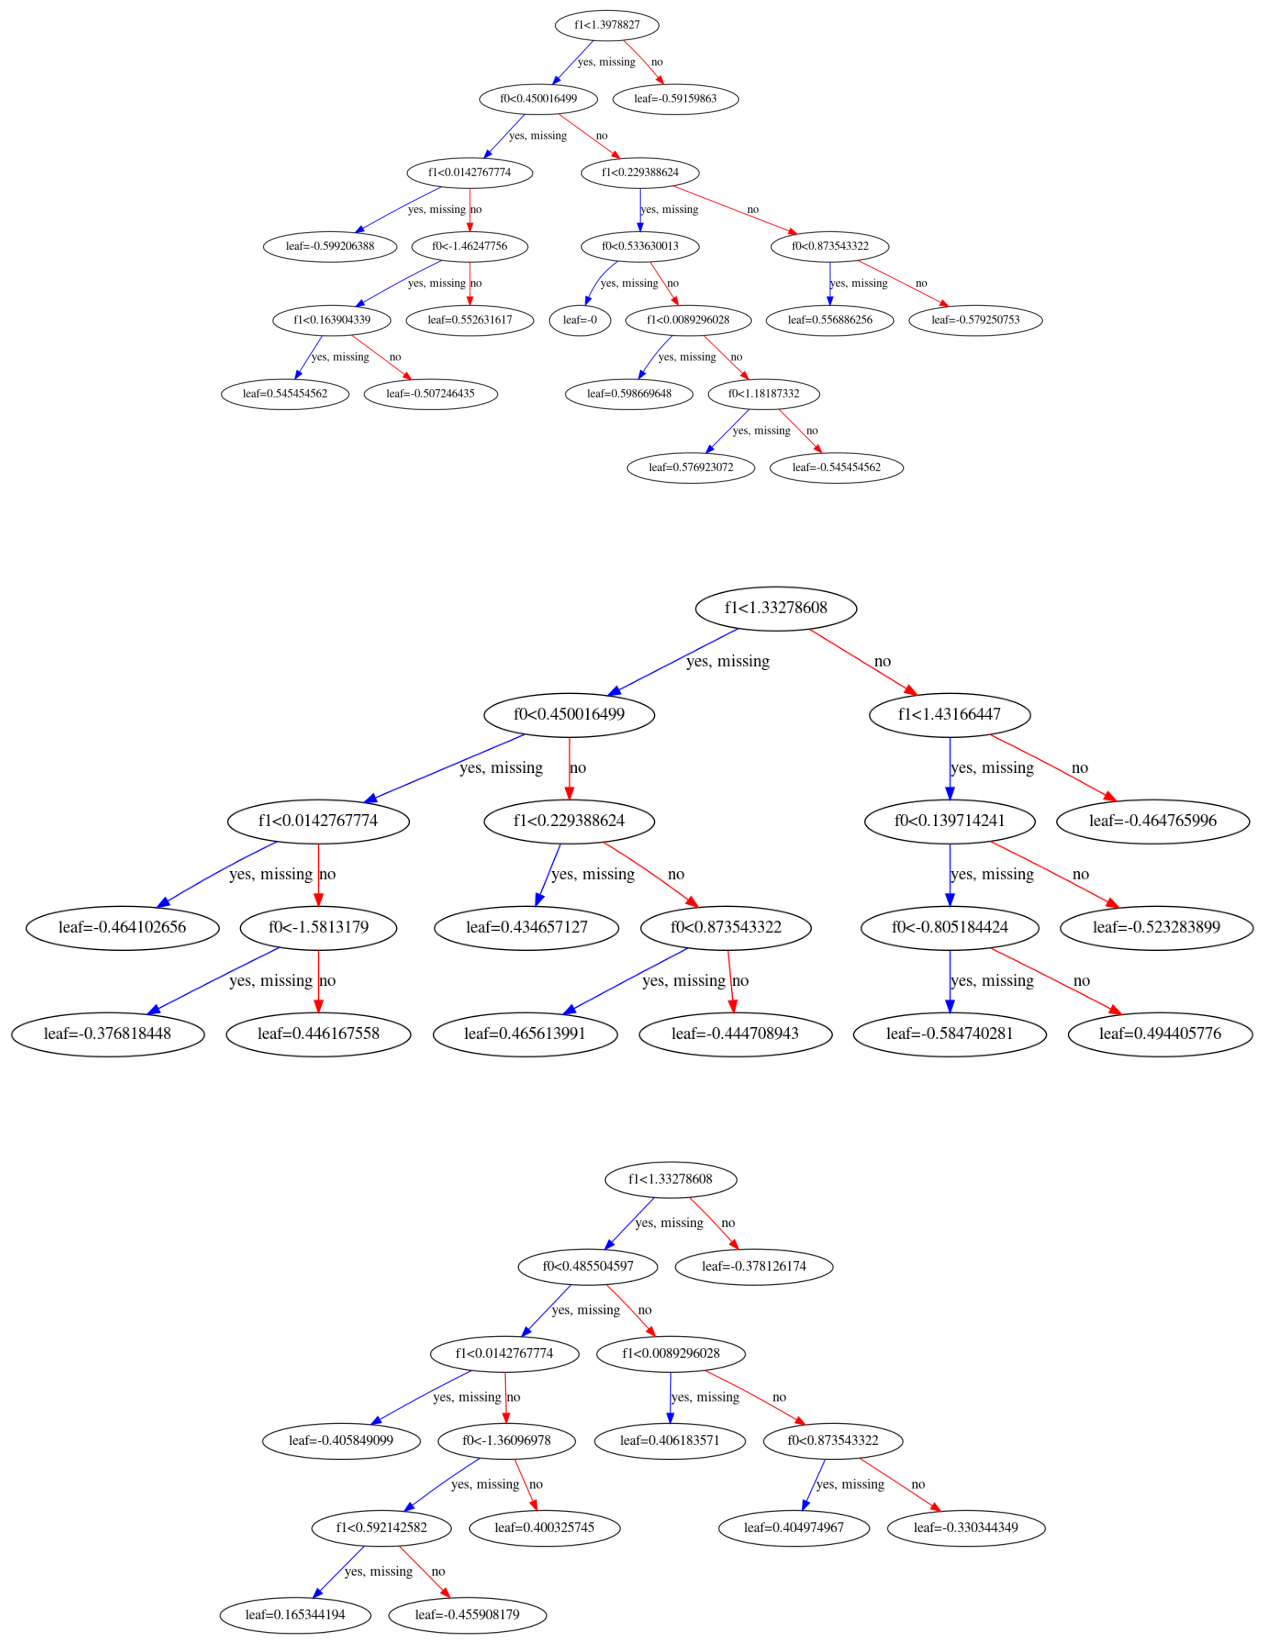

In [40]:
params['reg_lambda'] = 0.1

for gamma in ([0]+[10**(-i) for i in [3,2,1,0,-1]]):
    params['gamma']=gamma
    print("GAMMA = ",params['gamma'])
    classify(XGBClassifier(**params),show=True)



As we can see, larger gamma results in less complicated trees; one can observe the consequences of this by looking at the decision boundary: for larger gammas, this is less "refined". The largest gamma parameter we can implement without compromising the model's accuracy turns out to be 1. With a smaller number of estimators (we set 15) it may happen that the single tree needs to be more complex thus requiring smaller gammas.

